In [71]:
import netket as nk
from netket.operator.spin import sigmax,sigmaz, identity, sigmam, sigmap
import jax
import pickle
import matplotlib.pyplot as plt
from netket.graph import Graph, Chain
from netket.models import MPSPeriodic
from netket.operator._local_operator import LocalOperator
import numpy as np
from utils import *
from ffn import MPSFFN
from mps_finite import MPSMod

In [72]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
N = 10

In [74]:
# Copyright 2021 The NetKet Authors - All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from typing import Any
import warnings

import igraph as ig
from flax import linen as nn
import jax
from jax import numpy as jnp
import numpy as np
from jax.nn.initializers import normal

from netket.utils import deprecate_dtype
from netket.graph import AbstractGraph, Chain
from netket.hilbert import AbstractHilbert
from netket.utils.types import NNInitFunc


@deprecate_dtype
class MPSMod(nn.Module):
    r"""
    A periodic Matrix Product State (MPS) for a quantum state of discrete
    degrees of freedom, wrapped as Jax machine.

    The MPS is defined as

    .. math:: \Psi(s_1,\dots s_N) = \mathrm{Tr} \left[ A[s_1]\dots A[s_N] \right] ,

    for arbitrary local quantum numbers :math:`s_i`, where :math:`A[s_1]` is a matrix
    of dimension (bdim,bdim), depending on the value of the local quantum number :math:`s_i`.
    """

    hilbert: AbstractHilbert
    """Hilbert space on which the state is defined."""
    graph: AbstractGraph
    """The graph on which the system is defined."""
    bond_dim: int
    """Virtual dimension of the MPS tensors."""
    diag: bool = False
    """Whether or not to use diagonal matrices in the MPS tensors."""
    symperiod: bool = None
    """
    Periodicity in the chain of MPS tensors.

    The chain of MPS tensors is constructed as a sequence of identical
    unit cells consisting of symperiod tensors. if None, symperiod equals the
    number of physical degrees of freedom.
    """
    
    kernel_init: NNInitFunc = normal(
        stddev=0.01
    )  # default standard deviation equals 1e-2
    """the initializer for the MPS weights."""
    param_dtype: Any = np.complex64
    """complex or float, whether the variational parameters of the MPS are real or complex."""

    def setup(self):
        L = self.hilbert.size
        phys_dim = self.hilbert.local_size

        self._L = L
        self._phys_dim = phys_dim

        # determine transformation from local states to indices
        local_states = np.array(self.hilbert.local_states)
        loc_vals_spacing = np.roll(local_states, -1)[0:-1] - local_states[0:-1]
        if np.max(loc_vals_spacing) == np.min(loc_vals_spacing):
            self._loc_vals_spacing = jnp.array(loc_vals_spacing[0])
        else:
            raise AssertionError(
                "JaxMpsPeriodic can only be used with evenly spaced hilbert local values"
            )
        self._loc_vals_bias = jnp.min(local_states)

        # check whether graph is periodic chain
        chain_graph = Chain(self.graph.n_edges).to_igraph()
        if not ig.Graph(edges=self.graph.edges()).isomorphic(chain_graph):
            warnings.warn(
                "Warning: graph is not isomorphic to chain with periodic boundary conditions",
                UserWarning,
            )

        # determine shape of unit cell
        if self.symperiod is None:
            self._symperiod = L
        else:
            self._symperiod = self.symperiod

        if L % self._symperiod == 0 and self._symperiod > 0:
            if self.diag:
                unit_cell_shape = (self._symperiod, phys_dim, self.bond_dim)
            else:
                unit_cell_shape = (
                    self._symperiod,
                    phys_dim,
                    self.bond_dim,
                    self.bond_dim,
                )
        else:
            raise AssertionError(
                "The number of degrees of freedom of the Hilbert space needs to be a multiple of the period of the MPS"
            )

        # define diagonal tensors with correct unit cell shape
        if self.diag:
            iden_tensors = jnp.ones(
                (self._symperiod, phys_dim, self.bond_dim), dtype=self.param_dtype
            )
        else:
            iden_tensors = jnp.repeat(
                jnp.eye(self.bond_dim, dtype=self.param_dtype)[jnp.newaxis, :, :],
                self._symperiod * phys_dim,
                axis=0,
            )
            iden_tensors = iden_tensors.reshape(
                self._symperiod, phys_dim, self.bond_dim, self.bond_dim
            )

        self.kernel = (
            self.param("kernel", self.kernel_init, unit_cell_shape, self.param_dtype)
            + iden_tensors
        )

        ## Gaussian sector part 
        self.phys_A = jnp.array([[[0,0],[1,0]],[[1,0],[0,0]],[[0,1],[0,0]]])

    @nn.compact
    def __call__(self, x):
        
        # expand diagonal to square matrices if diagonal mps
        if self.diag:
            params = jnp.einsum(
                "ijk,kl->ijkl", self.kernel, jnp.eye(self.kernel.shape[-1])
            )
        else:
            params = self.kernel
        
        # create all tensors in mps from unit cell
        all_tensors = jnp.tile(params, (self._L // self._symperiod, 1, 1, 1))
        all_phystensors = jnp.tile(self.phys_A, (self._L, 1, 1, 1))
        # transform input to indices
        x = (x - self._loc_vals_bias) / self._loc_vals_spacing
        if len(x.shape) == 1:  # batch size is one
            x = jnp.expand_dims(x, 0)

        def select_tensor(tensor, index):
            return tensor[index.astype(int)]

        def select_all_tensors(all_tensors, indices):
            return jax.vmap(select_tensor)(all_tensors, indices)

        # select right tensors using input for matrix multiplication
        selected_tensors = jax.vmap(select_all_tensors, (None, 0))(all_tensors, x)
        sel_phys_tensors = jax.vmap(select_all_tensors, (None, 0))(all_phystensors, x)

        # create loop carry, in this case a unit matrix
        edges = jnp.repeat(
            jnp.eye(self.bond_dim, dtype=selected_tensors.dtype)[jnp.newaxis, :, :],
            selected_tensors.shape[0],
            axis=0,
        )
        edges_phys = jnp.repeat(
            jnp.eye(2, dtype=sel_phys_tensors.dtype)[jnp.newaxis, :, :],
            sel_phys_tensors.shape[0],
            axis=0,
        )

        def trace_mps(tensors, edge):
            def multiply_tensors(left_tensor, right_tensor):
                return jnp.einsum("ij,jk->ik", left_tensor, right_tensor), None

            edge, _ = jax.lax.scan(multiply_tensors, edge, tensors)
            
            return jnp.trace(edge)
        
        def sum_coeff(tensors, edge,):
            def multiply_tensors(left_tensor, right_tensor):
                return jnp.einsum("ij,jk->ik", left_tensor, right_tensor), None

            edge, _ = jax.lax.scan(multiply_tensors, edge, tensors)
            return jnp.trace(jnp.einsum("ij,jk->ik", edge, edge.transpose()))
        
        # trace the matrix multiplication
        return jnp.log(1+jax.vmap(trace_mps)(selected_tensors, edges)*jax.vmap(sum_coeff)(sel_phys_tensors, edges_phys))

In [75]:
spin_1_hilbert = nk.hilbert.Spin(1,N)

In [76]:
c = Chain(N)

In [77]:
mp= MPSMod(spin_1_hilbert,c, bond_dim=10, symperiod=1)
key1,key2 = jax.random.split(jax.random.key(0))
params = mp.init(key1,spin_1_hilbert.random_state(jax.random.key(1)))

In [78]:
# spin_1_hilbert.all_states()[14762]

In [79]:
# mp.apply(params,np.array(spin_1_hilbert.all_states()[14762]))


### We first print various properties of our Hilbert Space and define the QLM spin 1 equivalent Hamiltonian
$$H = -\frac{t}{2}\sum_i(S_i^+ S_{i+1}^-P_i^{(0)}P_{i+1}^{(0)}+ S_i^- S_{i+1}^+ P_i^{(1)} P_{i+1}^{(-1)}) -m\sum_i(S_i^z)^2 + \frac{g^2}{2}\sum_i (S_i^z +1 - (S_i^z)^2 - (-1)^iE_0)^2$$

In [80]:
print(spin_1_hilbert.size, spin_1_hilbert.shape, spin_1_hilbert.local_states)

10 (3, 3, 3, 3, 3, 3, 3, 3, 3, 3) [-2.0, 0.0, 2.0]


In [81]:
spin_1_hilbert.local_size

3

In [82]:
def f_init(parmas, sigma):
    phys_space = np.where(to_array(mp, params, spin_1_hilbert) != 0)
    pdf_init = np.zeros(len(spin_1_hilbert.all_states()))
    pdf_init[phys_space[0]] = 1/len(phys_space[0])
    return pdf_init

In [83]:
proj(spin_1_hilbert,1,0)

LocalOperator(dim=10, acting_on=[(1,)], constant=0.0, dtype=float64)

We implement the Hamiltonian shown above with boundary conditions imposing the presence of a fermion on the first site (site 0, even site) and no fermions on the last one (site N-1, odd site) This is equivalent to enforcing $(S^z_0)^2 = (S^z_{N-1})^2 = 0$ in the spin one formalism.

In [104]:
from tqdm import tqdm
from scipy.sparse.linalg import eigsh

def optimize_vstate(m, t=0, n_steps = 300, ed_compute = True, mc=False, err_thresh = 1e-7):
    H = create_ham(m, N, spin_1_hilbert, t = t)
    H_hop = create_ham(0,N,spin_1_hilbert,1000,l_cons=0)
    # vstate  = nk.vqs.MCState(nk.sampler.MetropolisSampler(spin_1_hilbert, rule=nk.sampler.rules.HamiltonianRule(H)), MPSMod(spin_1_hilbert,c, bond_dim=10, symperiod=2), n_samples=1000, )
    if mc :
        vstate  = nk.vqs.MCState(nk.sampler.MetropolisSampler(spin_1_hilbert, rule = nk.sampler.rules.HamiltonianRule(H_hop)), MPSPeriodic(spin_1_hilbert,c, bond_dim=10, symperiod=2), n_samples=1000)
  
    else :
        vstate  = nk.vqs.MCState(nk.sampler.ExactSampler(spin_1_hilbert), MPSMod(spin_1_hilbert,c, bond_dim=10, symperiod=2), n_samples=1000)
    
    # vstate.sampler.init_state(f_init, np.zeros(1),0)
    if ed_compute:
        eig_vals, eig_vecs = eigsh(H.to_sparse(), k=2, which="SA")

        print("eigenvalues with scipy sparse:", eig_vals)

        E_gs = eig_vals[0]
        print(E_gs)
    
    energy_history = []
    n_steps = n_steps

    for i in tqdm(range(n_steps)):
        # compute energy and gradient of the energy
        E, E_grad = vstate.expect_and_grad(H)
        if i%10 == 0:
            print(E)
            print("Mean                  :", E.mean)
            print("Error                 :", E.error_of_mean)
            print("Variance              :", E.variance)
            print("Convergence indicator :", E.R_hat)
            print("Correlation time      :", E.tau_corr)
            print(vstate.sample())
        # log the energy to a list
        energy_history.append(E.mean.real)
        # equivalent to vstate.parameters - 0.05*E_grad , but it performs this
        # function on every leaf of the dictionaries containing the set of parameters
        new_pars = jax.tree_map(lambda x,y: x-0.01*0.99**i*y, vstate.parameters, E_grad)
        # actually update the paramters
        vstate.parameters = new_pars
        if E.variance < err_thresh:
            break
    return vstate, energy_history

SyntaxError: unmatched ')' (123895930.py, line 9)

In [85]:
# a = to_array(mp,params,spin_1_hilbert)

In [86]:
spin_1_hilbert.states_to_numbers(np.array([[2 for i in range(N)]]))

array([59048], dtype=int64)

In [87]:
spin_1_hilbert.states_to_numbers(np.array([[-2.,  0.,  0.,  0.,  0.,  2., -2.,  2., -2.,  2.]]))

array([9902], dtype=int64)

In [88]:
spin_1_hilbert.all_states()[14762]

array([-2.,  2., -2.,  2., -2.,  2., -2.,  2., -2.,  2.])

In [89]:
H = create_ham(10, N = N, spin_1_hilbert=spin_1_hilbert)
# H = sigmap(spin_1_hilbert,0)

In [90]:
# m = 0
# idm = 0
# for id in phys_space[0]:
#     e = compute_energy(mp, params, H.to_sparse(), spin_1_hilbert, id)
#     if e < m :
#         m = e
#         idm = id
#idm

In [91]:
spin_1_hilbert.all_states()[2]

array([-2., -2., -2., -2., -2., -2., -2., -2., -2.,  2.])

In [92]:
compute_state_energy(H.to_sparse(), spin_1_hilbert, 9902)

-127.0

c:\Users\antoi\anaconda3\envs\netket_env\Lib\site-packages\netket\vqs\mc\mc_state\state.py:259: UserWarning: n_samples=1000 (1000 per MPI rank) does not divide n_chains=16, increased to 1008 (1008 per MPI rank)
  self.n_samples = n_samples


eigenvalues with scipy sparse: [-215. -215.]
-215.00000000000034


  2%|▏         | 1/50 [00:07<06:00,  7.36s/it]

(2, 3, 10, 10)
158.9+0.0j ± 7.1 [σ²=50565.5, R̂=1.0167]
Mean                  : (158.9345238095238+0j)
Error                 : 7.08266523449971
Variance              : 50565.45999858272
Convergence indicator : 1.0167264967821126
Correlation time      : 3.3306690738754696e-16


  4%|▍         | 2/50 [00:08<02:50,  3.56s/it]

(2, 3, 10, 10)


  6%|▌         | 3/50 [00:09<01:50,  2.35s/it]

(2, 3, 10, 10)


  8%|▊         | 4/50 [00:09<01:19,  1.74s/it]

(2, 3, 10, 10)


 10%|█         | 5/50 [00:10<01:03,  1.41s/it]

(2, 3, 10, 10)


 12%|█▏        | 6/50 [00:11<00:54,  1.23s/it]

(2, 3, 10, 10)


 14%|█▍        | 7/50 [00:12<00:48,  1.12s/it]

(2, 3, 10, 10)


 16%|█▌        | 8/50 [00:13<00:44,  1.07s/it]

(2, 3, 10, 10)


 18%|█▊        | 9/50 [00:14<00:42,  1.05s/it]

(2, 3, 10, 10)


 20%|██        | 10/50 [00:15<00:39,  1.02it/s]

(2, 3, 10, 10)


 22%|██▏       | 11/50 [00:16<00:37,  1.03it/s]

(2, 3, 10, 10)
-66.7+0.0j ± 2.7 [σ²=7413.7, R̂=1.3233]
Mean                  : (-66.72023809523809+0j)
Error                 : 2.711983902844219
Variance              : 7413.69554280045
Convergence indicator : 1.3232924293788133
Correlation time      : 2.220446049250313e-16


 24%|██▍       | 12/50 [00:17<00:36,  1.05it/s]

(2, 3, 10, 10)


 26%|██▌       | 13/50 [00:18<00:35,  1.04it/s]

(2, 3, 10, 10)


 28%|██▊       | 14/50 [00:19<00:34,  1.04it/s]

(2, 3, 10, 10)


 30%|███       | 15/50 [00:20<00:32,  1.07it/s]

(2, 3, 10, 10)


 32%|███▏      | 16/50 [00:20<00:31,  1.09it/s]

(2, 3, 10, 10)


 34%|███▍      | 17/50 [00:21<00:29,  1.13it/s]

(2, 3, 10, 10)


 36%|███▌      | 18/50 [00:22<00:27,  1.18it/s]

(2, 3, 10, 10)


 38%|███▊      | 19/50 [00:23<00:26,  1.16it/s]

(2, 3, 10, 10)


 40%|████      | 20/50 [00:24<00:26,  1.12it/s]

(2, 3, 10, 10)


 42%|████▏     | 21/50 [00:25<00:26,  1.09it/s]

(2, 3, 10, 10)
-73.9+0.0j ± 3.9 [σ²=14945.0, R̂=1.3138]
Mean                  : (-73.86309523809524+0j)
Error                 : 3.8505056700760325
Variance              : 14945.005066609983
Convergence indicator : 1.3137994075575012
Correlation time      : 0.0


 44%|████▍     | 22/50 [00:26<00:24,  1.12it/s]

(2, 3, 10, 10)


 46%|████▌     | 23/50 [00:26<00:23,  1.15it/s]

(2, 3, 10, 10)


 48%|████▊     | 24/50 [00:27<00:22,  1.13it/s]

(2, 3, 10, 10)


 50%|█████     | 25/50 [00:28<00:22,  1.12it/s]

(2, 3, 10, 10)


 52%|█████▏    | 26/50 [00:29<00:21,  1.14it/s]

(2, 3, 10, 10)


 54%|█████▍    | 27/50 [00:30<00:20,  1.12it/s]

(2, 3, 10, 10)


 56%|█████▌    | 28/50 [00:31<00:19,  1.10it/s]

(2, 3, 10, 10)


 58%|█████▊    | 29/50 [00:32<00:18,  1.11it/s]

(2, 3, 10, 10)


 60%|██████    | 30/50 [00:33<00:17,  1.14it/s]

(2, 3, 10, 10)


 62%|██████▏   | 31/50 [00:34<00:16,  1.14it/s]

(2, 3, 10, 10)
-52.3+0.0j ± 4.5 [σ²=20756.9, R̂=1.3620]
Mean                  : (-52.31547619047619+0j)
Error                 : 4.53786408021842
Variance              : 20756.948093820876
Convergence indicator : 1.3619960507231967
Correlation time      : 0.0


 64%|██████▍   | 32/50 [00:35<00:16,  1.12it/s]

(2, 3, 10, 10)


 66%|██████▌   | 33/50 [00:35<00:14,  1.14it/s]

(2, 3, 10, 10)


 68%|██████▊   | 34/50 [00:36<00:14,  1.12it/s]

(2, 3, 10, 10)


 70%|███████   | 35/50 [00:37<00:12,  1.16it/s]

(2, 3, 10, 10)


 72%|███████▏  | 36/50 [00:38<00:12,  1.13it/s]

(2, 3, 10, 10)


 74%|███████▍  | 37/50 [00:39<00:11,  1.17it/s]

(2, 3, 10, 10)


 76%|███████▌  | 38/50 [00:40<00:10,  1.14it/s]

(2, 3, 10, 10)


 78%|███████▊  | 39/50 [00:41<00:10,  1.09it/s]

(2, 3, 10, 10)


 80%|████████  | 40/50 [00:42<00:09,  1.06it/s]

(2, 3, 10, 10)


 82%|████████▏ | 41/50 [00:43<00:09,  1.04s/it]

(2, 3, 10, 10)
-63.6+0.0j ± 4.4 [σ²=19300.5, R̂=1.2690]
Mean                  : (-63.56547619047619+0j)
Error                 : 4.375770826005776
Variance              : 19300.549284297056
Convergence indicator : 1.2690250337407598
Correlation time      : 0.0


 84%|████████▍ | 42/50 [00:44<00:07,  1.01it/s]

(2, 3, 10, 10)


 86%|████████▌ | 43/50 [00:45<00:07,  1.01s/it]

(2, 3, 10, 10)


 88%|████████▊ | 44/50 [00:46<00:06,  1.06s/it]

(2, 3, 10, 10)


 90%|█████████ | 45/50 [00:47<00:04,  1.00it/s]

(2, 3, 10, 10)


 92%|█████████▏| 46/50 [00:48<00:03,  1.06it/s]

(2, 3, 10, 10)


 94%|█████████▍| 47/50 [00:49<00:02,  1.11it/s]

(2, 3, 10, 10)


 96%|█████████▌| 48/50 [00:49<00:01,  1.12it/s]

(2, 3, 10, 10)


 98%|█████████▊| 49/50 [00:50<00:00,  1.17it/s]

(2, 3, 10, 10)


100%|██████████| 50/50 [00:51<00:00,  1.03s/it]

(2, 3, 10, 10)


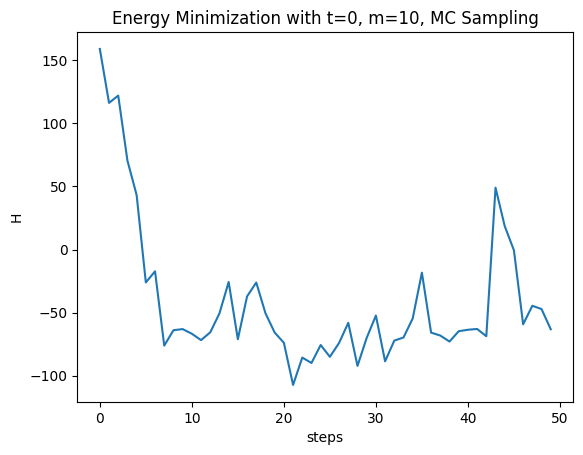

<Figure size 640x480 with 0 Axes>

In [101]:
v,e = optimize_vstate(10, 0, n_steps = 50, ed_compute=True, mc=True)
plt.plot(e)
plt.xlabel("steps")
plt.ylabel("H")
plt.title("Energy Minimization with t=0, m=10, MC Sampling")
plt.show()
plt.clf()

In [ ]:
# H = create_ham(10, N, spin_1_hilbert)
# v.sample()[0]

In [ ]:
# compute_state_energy(H.to_sparse(), spin_1_hilbert, 9902)

In [ ]:
# vars(v)

  2%|▏         | 1/50 [00:05<04:24,  5.39s/it]

396.2+0.0j ± 6.9 [σ²=50822.2]
Mean                  : (396.2384928896204+0.00047323918495385445j)
Error                 : 6.914174998934907
Variance              : 50822.24436482852
Convergence indicator : nan
Correlation time      : 0.0


 22%|██▏       | 11/50 [00:24<01:12,  1.86s/it]

178.1+0.0j ± 2.4 [σ²=6115.4]
Mean                  : (178.1414342401242+0.0003806119934124582j)
Error                 : 2.393865397478797
Variance              : 6115.354134951101
Convergence indicator : nan
Correlation time      : 0.0


 42%|████▏     | 21/50 [00:41<00:50,  1.75s/it]

143.6+0.0j ± 2.0 [σ²=3399.8]
Mean                  : (143.6390160518808+0.00025870225104154094j)
Error                 : 2.0389529697561253
Variance              : 3399.794320693452
Convergence indicator : nan
Correlation time      : 0.11140892958921089


 62%|██████▏   | 31/50 [00:59<00:34,  1.80s/it]

112.3+0.0j ± 1.4 [σ²=2456.0]
Mean                  : (112.25450206771353+0.0005448813745751977j)
Error                 : 1.4481323239976291
Variance              : 2456.013814297252
Convergence indicator : nan
Correlation time      : 0.0


 82%|████████▏ | 41/50 [01:17<00:16,  1.81s/it]

90.2+0.0j ± 1.2 [σ²=1380.9]
Mean                  : (90.24714083909244+0.0003636635539442068j)
Error                 : 1.243379347164801
Variance              : 1380.8518700472252
Convergence indicator : nan
Correlation time      : 0.059796540994326075


100%|██████████| 50/50 [01:34<00:00,  1.88s/it]


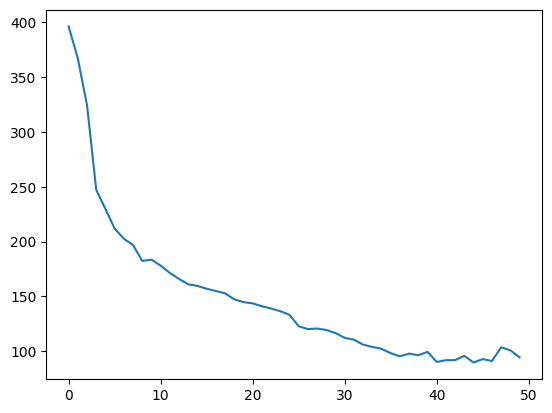

  2%|▏         | 1/50 [00:03<02:33,  3.13s/it]

386.1+0.0j ± 7.3 [σ²=51022.2]
Mean                  : (386.0617255265573+0.00029410844418453075j)
Error                 : 7.294394629540234
Variance              : 51022.22505957401
Convergence indicator : nan
Correlation time      : 0.021421723075963794


 22%|██▏       | 11/50 [00:20<01:09,  1.78s/it]

160.8+0.0j ± 2.0 [σ²=4957.5]
Mean                  : (160.76891090820743+0.00014494425046177644j)
Error                 : 2.020150386426718
Variance              : 4957.508289657743
Convergence indicator : nan
Correlation time      : 0.0


 42%|████▏     | 21/50 [00:38<00:50,  1.73s/it]

134.5-0.0j ± 1.8 [σ²=3191.5]
Mean                  : (134.46378277553387-4.124460749380888e-05j)
Error                 : 1.7676833426830112
Variance              : 3191.5032734261413
Convergence indicator : nan
Correlation time      : 0.0


 62%|██████▏   | 31/50 [00:55<00:33,  1.76s/it]

103.0-0.0j ± 1.4 [σ²=2302.1]
Mean                  : (103.0147063330421-9.718001479632222e-05j)
Error                 : 1.4039176977346395
Variance              : 2302.0743055018424
Convergence indicator : nan
Correlation time      : 0.0


 82%|████████▏ | 41/50 [01:13<00:16,  1.81s/it]

87.24-0.00j ± 0.93 [σ²=781.78]
Mean                  : (87.24096539938941-9.804500800964891e-05j)
Error                 : 0.9342889508693797
Variance              : 781.7787548415091
Convergence indicator : nan
Correlation time      : 0.058275495663456245


100%|██████████| 50/50 [01:30<00:00,  1.81s/it]


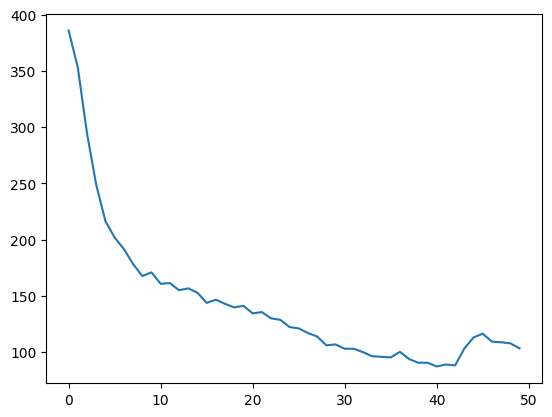

  2%|▏         | 1/50 [00:02<02:05,  2.56s/it]

357.8-0.0j ± 7.8 [σ²=51374.1]
Mean                  : (357.8138674979408-0.00012829722296919506j)
Error                 : 7.841101962796268
Variance              : 51374.12504302478
Convergence indicator : nan
Correlation time      : 0.09838371884170116


 22%|██▏       | 11/50 [00:20<01:08,  1.76s/it]

160.2+0.0j ± 2.2 [σ²=5957.2]
Mean                  : (160.15678284167808+0.00013347693120977058j)
Error                 : 2.1819880877233007
Variance              : 5957.211627463
Convergence indicator : nan
Correlation time      : 0.0


 42%|████▏     | 21/50 [00:38<00:52,  1.80s/it]

137.1+0.0j ± 1.9 [σ²=3843.6]
Mean                  : (137.09865963450764+0.00011912544781262117j)
Error                 : 1.9477685037915098
Variance              : 3843.611235567327
Convergence indicator : nan
Correlation time      : 0.0


 62%|██████▏   | 31/50 [00:56<00:34,  1.79s/it]

109.3+0.0j ± 1.3 [σ²=2299.2]
Mean                  : (109.27660485196425+0.00019060044160966073j)
Error                 : 1.3418593312683216
Variance              : 2299.22305966652
Convergence indicator : nan
Correlation time      : 0.0


 82%|████████▏ | 41/50 [01:14<00:16,  1.87s/it]

93.8+0.0j ± 1.4 [σ²=2675.2]
Mean                  : (93.7811447222339+2.622699219500632e-06j)
Error                 : 1.3814481087672588
Variance              : 2675.210099503331
Convergence indicator : nan
Correlation time      : 0.0


100%|██████████| 50/50 [01:31<00:00,  1.83s/it]


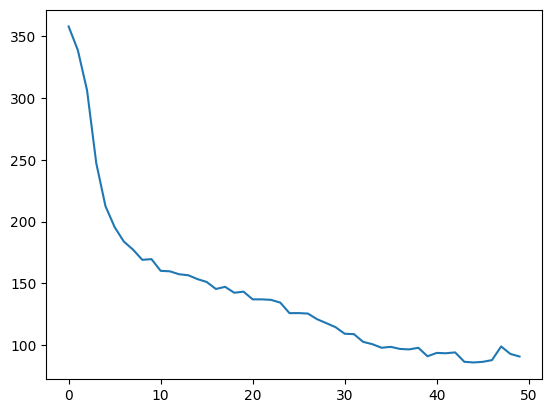

  2%|▏         | 1/50 [00:02<01:56,  2.38s/it]

360.6-0.0j ± 6.8 [σ²=52556.2]
Mean                  : (360.58813849754387-8.599468643399183e-05j)
Error                 : 6.770482126783092
Variance              : 52556.242288411544
Convergence indicator : nan
Correlation time      : 0.0


 22%|██▏       | 11/50 [00:20<01:08,  1.77s/it]

150.9-0.0j ± 2.4 [σ²=4180.0]
Mean                  : (150.8647157914083-0.00025358487556877666j)
Error                 : 2.42832294551046
Variance              : 4179.961520687474
Convergence indicator : nan
Correlation time      : 0.20535964248813976


 42%|████▏     | 21/50 [00:37<00:50,  1.76s/it]

140.2-0.0j ± 1.8 [σ²=3960.5]
Mean                  : (140.15556036727537-0.0003770521248661681j)
Error                 : 1.7992149401952549
Variance              : 3960.464955529305
Convergence indicator : nan
Correlation time      : 0.0


 62%|██████▏   | 31/50 [00:55<00:33,  1.75s/it]

124.7-0.0j ± 1.7 [σ²=3451.2]
Mean                  : (124.72634789215098-0.0006604474764390035j)
Error                 : 1.6754996441388321
Variance              : 3451.2151239914083
Convergence indicator : nan
Correlation time      : 0.0


 82%|████████▏ | 41/50 [01:13<00:16,  1.79s/it]

96.1-0.0j ± 1.7 [σ²=3012.0]
Mean                  : (96.06187242425376-0.0015938261896517364j)
Error                 : 1.6668715862490302
Variance              : 3012.0194897169845
Convergence indicator : nan
Correlation time      : 0.0


100%|██████████| 50/50 [01:30<00:00,  1.80s/it]


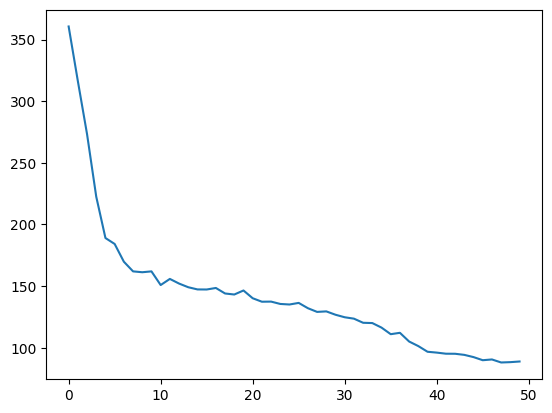

  2%|▏         | 1/50 [00:02<01:52,  2.30s/it]

331.1+0.0j ± 5.8 [σ²=51059.9]
Mean                  : (331.1470990068464+0.00013680260490946244j)
Error                 : 5.793159087074771
Variance              : 51059.86120256545
Convergence indicator : nan
Correlation time      : 0.0


 22%|██▏       | 11/50 [00:20<01:09,  1.79s/it]

145.1-0.0j ± 2.5 [σ²=7760.9]
Mean                  : (145.10344704518096-0.00015318227423131252j)
Error                 : 2.5015720212930788
Variance              : 7760.930678580664
Convergence indicator : nan
Correlation time      : 0.0


 42%|████▏     | 21/50 [00:37<00:51,  1.77s/it]

137.3-0.0j ± 2.3 [σ²=4575.9]
Mean                  : (137.28955599100195-4.861883855471661e-05j)
Error                 : 2.2918772557040783
Variance              : 4575.93707654652
Convergence indicator : nan
Correlation time      : 0.07394816267642979


 62%|██████▏   | 31/50 [00:56<00:36,  1.92s/it]

132.9+0.0j ± 1.8 [σ²=3441.1]
Mean                  : (132.87189190588234+3.079030187950593e-05j)
Error                 : 1.8047675778004975
Variance              : 3441.0786366521784
Convergence indicator : nan
Correlation time      : 0.0


 82%|████████▏ | 41/50 [01:14<00:16,  1.78s/it]

131.3+0.0j ± 1.7 [σ²=2791.3]
Mean                  : (131.2546042754772+6.386376255579764e-05j)
Error                 : 1.6615479418075028
Variance              : 2791.3404109784274
Convergence indicator : nan
Correlation time      : 0.0


100%|██████████| 50/50 [01:30<00:00,  1.80s/it]


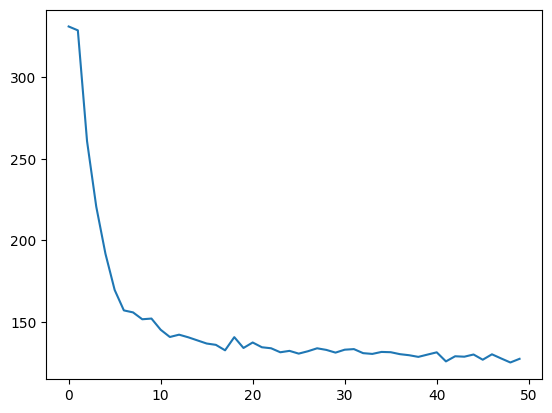

  2%|▏         | 1/50 [00:02<01:58,  2.42s/it]

325.0-0.0j ± 8.4 [σ²=50708.2]
Mean                  : (324.9835990796314-0.0001440033949620558j)
Error                 : 8.41745437393822
Variance              : 50708.17652725495
Convergence indicator : nan
Correlation time      : 0.19864016998569112


 22%|██▏       | 11/50 [00:20<01:09,  1.78s/it]

129.2-0.0j ± 2.4 [σ²=6151.4]
Mean                  : (129.2036778795312-0.00021236803189185596j)
Error                 : 2.4499603355928974
Variance              : 6151.443187643914
Convergence indicator : nan
Correlation time      : 0.0


 42%|████▏     | 21/50 [00:37<00:51,  1.76s/it]

97.0-0.0j ± 1.4 [σ²=1776.9]
Mean                  : (96.956718554416-9.454469045158478e-05j)
Error                 : 1.3842586170075493
Variance              : 1776.9096549577844
Convergence indicator : nan
Correlation time      : 0.03918664728206944


 62%|██████▏   | 31/50 [00:55<00:32,  1.73s/it]

82.01-0.00j ± 0.62 [σ²=463.39]
Mean                  : (82.01053398240889-2.078617434563057e-05j)
Error                 : 0.6152027122984233
Variance              : 463.38657666865623
Convergence indicator : nan
Correlation time      : 0.0


 82%|████████▏ | 41/50 [01:14<00:17,  1.90s/it]

76.71-0.00j ± 0.42 [σ²=160.70]
Mean                  : (76.71051753108027-1.8522811908042062e-05j)
Error                 : 0.4159548061066906
Variance              : 160.70160981855048
Convergence indicator : nan
Correlation time      : 0.03832192757313102


100%|██████████| 50/50 [01:29<00:00,  1.79s/it]


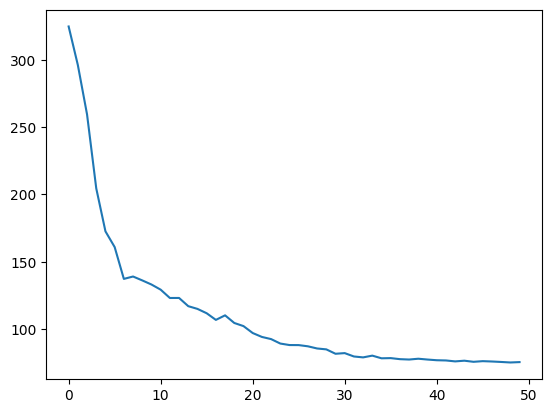

  2%|▏         | 1/50 [00:02<01:57,  2.41s/it]

312.3-0.0j ± 6.4 [σ²=51376.0]
Mean                  : (312.291578667437-4.7294829942984615e-05j)
Error                 : 6.442424284247877
Variance              : 51375.99972940594
Convergence indicator : nan
Correlation time      : 0.0


 22%|██▏       | 11/50 [00:20<01:09,  1.77s/it]

113.4+0.0j ± 2.7 [σ²=6273.0]
Mean                  : (113.41630914882437+0.00010317671981647437j)
Error                 : 2.7065956438999668
Variance              : 6272.99825695292
Convergence indicator : nan
Correlation time      : 0.0839041937767635


 42%|████▏     | 21/50 [00:37<00:48,  1.68s/it]

68.7-0.0j ± 1.0 [σ²=1142.9]
Mean                  : (68.66138951620945-1.3229704865807437e-05j)
Error                 : 1.0245601978802203
Variance              : 1142.9421638051035
Convergence indicator : nan
Correlation time      : 0.0


 62%|██████▏   | 31/50 [00:54<00:32,  1.70s/it]

55.91-0.00j ± 0.41 [σ²=251.37]
Mean                  : (55.91281557744263-9.472642845139491e-06j)
Error                 : 0.4066549106642692
Variance              : 251.3667353467056
Convergence indicator : nan
Correlation time      : 0.0


 82%|████████▏ | 41/50 [01:11<00:14,  1.66s/it]

53.20-0.00j ± 0.30 [σ²=86.59]
Mean                  : (53.20183852216326-6.773635658191781e-06j)
Error                 : 0.30033831584938775
Variance              : 86.58774664314737
Convergence indicator : nan
Correlation time      : 0.020876841494669618


100%|██████████| 50/50 [01:28<00:00,  1.77s/it]


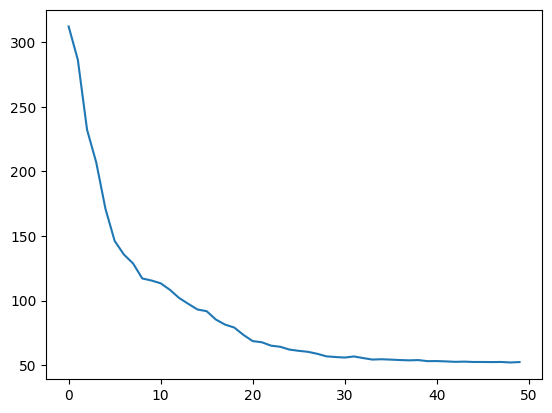

  2%|▏         | 1/50 [00:02<01:50,  2.26s/it]

297.9+0.0j ± 7.0 [σ²=48670.0]
Mean                  : (297.9495286432953+2.157051094400231e-06j)
Error                 : 6.974874992209433
Variance              : 48670.01748093593
Convergence indicator : nan
Correlation time      : 0.0


 22%|██▏       | 11/50 [00:21<01:14,  1.92s/it]

89.2+0.0j ± 2.5 [σ²=6460.5]
Mean                  : (89.17328448219426+5.124422725748446e-05j)
Error                 : 2.5068718424072767
Variance              : 6460.519008509681
Convergence indicator : nan
Correlation time      : 0.0


 42%|████▏     | 21/50 [00:39<00:48,  1.68s/it]

39.00+0.00j ± 0.89 [σ²=756.32]
Mean                  : (39.00067593045157+8.219211403229566e-06j)
Error                 : 0.8863989723200362
Variance              : 756.3173455745576
Convergence indicator : nan
Correlation time      : 0.01942689317348323


 62%|██████▏   | 31/50 [00:55<00:31,  1.64s/it]

31.74+0.00j ± 0.35 [σ²=146.58]
Mean                  : (31.744004274003842+4.979221403118572e-06j)
Error                 : 0.3483149315332756
Variance              : 146.58148844101697
Convergence indicator : nan
Correlation time      : 0.0


 82%|████████▏ | 41/50 [01:14<00:17,  1.95s/it]

29.96+0.00j ± 0.19 [σ²=29.54]
Mean                  : (29.96230938724676+4.753003804580659e-06j)
Error                 : 0.18772295514037415
Variance              : 29.544690448153148
Convergence indicator : nan
Correlation time      : 0.09638309544105894


100%|██████████| 50/50 [01:29<00:00,  1.79s/it]


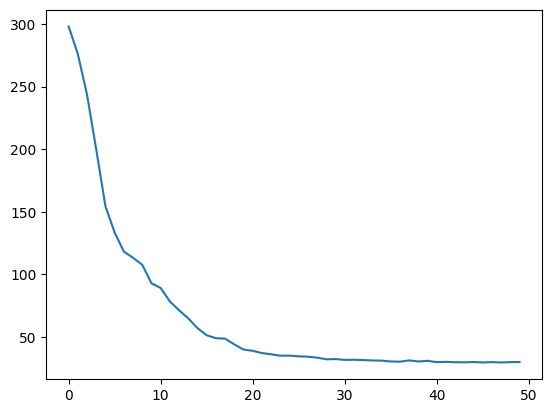

  2%|▏         | 1/50 [00:02<01:44,  2.14s/it]

295.1-0.0j ± 7.5 [σ²=51635.3]
Mean                  : (295.0576160314976-0.0002916771821492149j)
Error                 : 7.545428277772777
Variance              : 51635.296782564
Convergence indicator : nan
Correlation time      : 0.05130396688489769


 22%|██▏       | 11/50 [00:19<01:10,  1.80s/it]

49.5+0.0j ± 2.3 [σ²=3724.8]
Mean                  : (49.46241705556156+0.0001087039190606447j)
Error                 : 2.2775113931472513
Variance              : 3724.831037315395
Convergence indicator : nan
Correlation time      : 0.19628099824549539


 42%|████▏     | 21/50 [00:37<00:52,  1.80s/it]

13.14+0.00j ± 0.65 [σ²=390.65]
Mean                  : (13.138620201938831+2.36637354546474e-05j)
Error                 : 0.6460365476455332
Variance              : 390.6458365822083
Convergence indicator : nan
Correlation time      : 0.03419642782488552


 62%|██████▏   | 31/50 [00:54<00:32,  1.72s/it]

8.54+0.00j ± 0.29 [σ²=84.08]
Mean                  : (8.536488062121105+1.588647594326176e-05j)
Error                 : 0.29040693081776686
Variance              : 84.08497900099049
Convergence indicator : nan
Correlation time      : 0.0014937654084553609


 82%|████████▏ | 41/50 [01:11<00:14,  1.63s/it]

8.18+0.00j ± 0.51 [σ²=278.98]
Mean                  : (8.179313791449717+9.582010793565132e-06j)
Error                 : 0.5053031872824313
Variance              : 278.9793185216831
Convergence indicator : nan
Correlation time      : 0.0


100%|██████████| 50/50 [01:26<00:00,  1.74s/it]


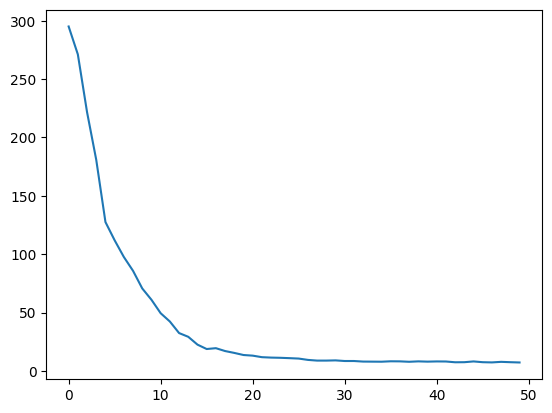

  2%|▏         | 1/50 [00:02<01:51,  2.27s/it]

268.1+0.0j ± 7.4 [σ²=51580.8]
Mean                  : (268.0713617092371+0.00019323469048322295j)
Error                 : 7.3707531927503025
Variance              : 51580.798076544954
Convergence indicator : nan
Correlation time      : 0.026630109016702486


 22%|██▏       | 11/50 [00:19<01:07,  1.73s/it]

16.5+0.0j ± 1.6 [σ²=2996.9]
Mean                  : (16.525183854569796+7.10211616187735e-05j)
Error                 : 1.647076968391947
Variance              : 2996.931819075252
Convergence indicator : nan
Correlation time      : 0.0


 42%|████▏     | 21/50 [00:36<00:49,  1.70s/it]

-10.66+0.00j ± 0.57 [σ²=294.41]
Mean                  : (-10.656248452193614+1.1626293449808148e-05j)
Error                 : 0.5676471531552133
Variance              : 294.4130955527235
Convergence indicator : nan
Correlation time      : 0.04722988778791337


 62%|██████▏   | 31/50 [00:53<00:31,  1.67s/it]

-14.26+0.00j ± 0.24 [σ²=59.97]
Mean                  : (-14.26015404068827+8.540844221897716e-06j)
Error                 : 0.24440341413571048
Variance              : 59.96978295775442
Convergence indicator : nan
Correlation time      : 0.0


 82%|████████▏ | 41/50 [01:10<00:15,  1.69s/it]

-14.938+0.000j ± 0.062 [σ²=3.840]
Mean                  : (-14.938132683592514+7.294249493952522e-06j)
Error                 : 0.0615142275017555
Variance              : 3.839973842404327
Convergence indicator : nan
Correlation time      : 0.0


100%|██████████| 50/50 [01:27<00:00,  1.74s/it]


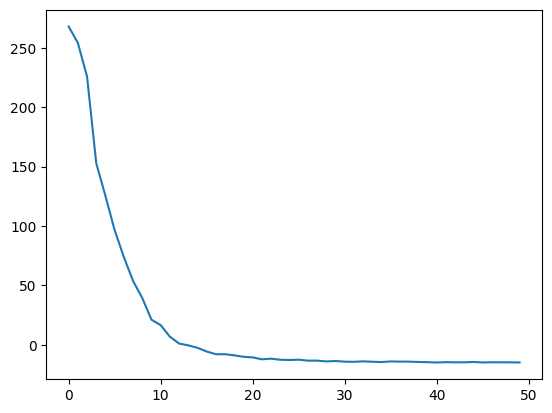

<Figure size 640x480 with 0 Axes>

In [ ]:
mu_vals = np.linspace(-10,0,10)
vstate_l = []
e_hist_l = []
for m in mu_vals:
    v,e = optimize_vstate(m, t=1, n_steps=50, ed_compute=False)
    vstate_l.append(v)
    e_hist_l.append(e)
    plt.plot(e)
    plt.show()
    plt.clf()

### We will compute the behavior of the electric flux $\varepsilon = \sum_x \frac{\langle S_{x,x+1}^{(z)}\rangle}{N}$, here referring to the spin 1/2 formulation. In the spin 1 formulation, we have something like : $\varepsilon = \sum_x \frac{\langle S_{x}^{(z)} - (S_{x}^z)^2\rangle}{2N}$ up to a constant.

In [ ]:
eps = np.sum([(sigmaz(spin_1_hilbert,n)*(1/2)+1-sigmaz(spin_1_hilbert,n)*sigmaz(spin_1_hilbert,n)*(1/4))*(1/2*N) for n in range(N)])

In [ ]:
eps = np.sum([(-1)**n*(-sigmaz(spin_1_hilbert,n)*(1/2)+1-sigmaz(spin_1_hilbert,n)*sigmaz(spin_1_hilbert,n)*(1/4))*(1/2*N) for n in range(N)])

Text(0.5, 1.0, 'Phase transition of the system for t=1 ')

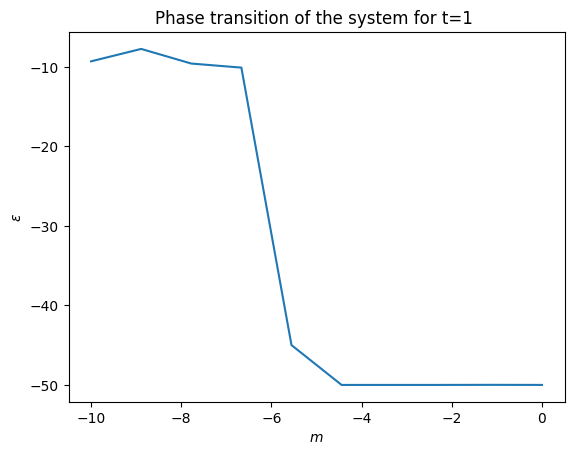

In [ ]:
plt.plot(mu_vals,[vstate_l[i].expect(eps).mean for i in range(len(vstate_l))])
plt.xlabel(r"$m$")
plt.ylabel(r"$\varepsilon$")
plt.title("Phase transition of the system for t=1 ")

In [ ]:
mu_vals = np.linspace(-10,0,10)
vstate_l = []
e_hist_l = []
for m in mu_vals:
    v,e = optimize_vstate(m, t=20, n_steps=50, ed_compute=False)
    vstate_l.append(v)
    e_hist_l.append(e)
    plt.plot(e)
    plt.show()
    plt.clf()